# Probando conexion con la base de datos

In [3]:
pip install python-dotenv

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Connect to the database
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )
    print("Connection successful!")
    
    # Create a cursor to execute SQL queries
    cursor = connection.cursor()
    
    # Example query
    cursor.execute("SELECT NOW();")
    result = cursor.fetchone()
    print("Current Time:", result)

    # Close the cursor and connection
    #cursor.close()
    #connection.close()
    #print("Connection closed.")

except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!
Current Time: (datetime.datetime(2025, 11, 13, 22, 21, 44, 460810, tzinfo=datetime.timezone.utc),)


## Listando tablas disponibles

In [3]:
cursor = connection.cursor()
cursor.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
""")

tables = cursor.fetchall()
print("Tablas encontradas:")
for table in tables:
    print(table[0])

cursor.close()

Tablas encontradas:
n8n_chat_histories
airbnb_listings_final
geography_columns
geometry_columns
spatial_ref_sys
scraped_data
tweets_results
google_search
instagram_posts
trivago_hoteles
facebook_posts


## Listando campos de la tabla facebook_posts

In [4]:
table_name = 'facebook_posts'  

cursor = connection.cursor()
cursor.execute("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = %s
""", (table_name,))

columns = cursor.fetchall()
print(f"Columnas en {table_name}:")
for column in columns:
    print(f"- {column[0]} ({column[1]})")

cursor.close()

Columnas en facebook_posts:
- comment_count (integer)
- view_count (integer)
- music (jsonb)
- reactions_count (integer)
- comments (jsonb)
- video (jsonb)
- created_at (timestamp with time zone)
- feedback_id (text)
- author_id (text)
- transcript (text)
- share_count (text)
- like_count (text)
- post_id (text)
- image_url (text)
- author (text)
- description (text)
- url (text)
- thumbnail (text)
- video_url (text)
- captions_url (text)


In [ ]:
pip install hdfs

# Seleccionamos la data

In [3]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Conexión a tu base de datos
connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME,
        connect_timeout=600
    )

chunksize = 5000   
offset = 0
first = True

while True:
    query = f"""
        SELECT * FROM facebook_posts
        LIMIT {chunksize} OFFSET {offset};
    """
    df = pd.read_sql(query, connection)
    
    if df.empty:
        print("Lectura completada")
        break

    df.to_csv(
        "facebook_posts.csv",
        mode='a',        
        index=False,
        header=first,    # escribe el header solo la 1ra vez
        encoding='utf-8',
        quoting=1
    )
    first = False
    offset += chunksize
    print(f"Chunk {offset} filas exportadas...")
    
print(df.head())
connection.close()

/tmp/ipykernel_8452/2268515075.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Chunk 5000 filas exportadas...


/tmp/ipykernel_8452/2268515075.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Chunk 10000 filas exportadas...


/tmp/ipykernel_8452/2268515075.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Chunk 15000 filas exportadas...


/tmp/ipykernel_8452/2268515075.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Chunk 20000 filas exportadas...


/tmp/ipykernel_8452/2268515075.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Chunk 25000 filas exportadas...


/tmp/ipykernel_8452/2268515075.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Chunk 30000 filas exportadas...


/tmp/ipykernel_8452/2268515075.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Chunk 35000 filas exportadas...


/tmp/ipykernel_8452/2268515075.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Chunk 40000 filas exportadas...


/tmp/ipykernel_8452/2268515075.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Lectura completada
Empty DataFrame
Columns: [post_id, author, description, url, thumbnail, video_url, captions_url, feedback_id, comment_count, view_count, reactions_count, comments, created_at, author_id, transcript, music, share_count, like_count, video, image_url]
Index: []


## Mostrando estructura del dataset

In [4]:
df = pd.read_csv('facebook_posts.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37999 entries, 0 to 37998
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_id          37999 non-null  object 
 1   author           37999 non-null  object 
 2   description      37997 non-null  object 
 3   url              42 non-null     object 
 4   thumbnail        4 non-null      object 
 5   video_url        4 non-null      object 
 6   captions_url     0 non-null      float64
 7   feedback_id      42 non-null     object 
 8   comment_count    37999 non-null  int64  
 9   view_count       37961 non-null  float64
 10  reactions_count  37999 non-null  int64  
 11  comments         37999 non-null  object 
 12  created_at       37999 non-null  object 
 13  author_id        38 non-null     object 
 14  transcript       0 non-null      float64
 15  music            0 non-null      float64
 16  share_count      38 non-null     float64
 17  like_count  

/tmp/ipykernel_8452/3486777732.py:1: DtypeWarning: Columns (3,4,5,7,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('facebook_posts.csv')


# Almacenamos los datos en HDFS

In [5]:
import subprocess

In [6]:
hdfs_path = "raw/facebook/facebook_posts.csv"

subprocess.run(["hdfs", "dfs", "-put", "-f", "facebook_posts.csv", hdfs_path], check=True)

print("Archivo cargado a HDFS:", hdfs_path)


Archivo cargado a HDFS: raw/facebook/facebook_posts.csv


# Procesamos los datos

## Realizando importaciones

In [7]:
import ast
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when,regexp_replace, from_json, explode
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType,FloatType, TimestampType

## Creando sesión de Spark e iniciando con la limpieza

In [8]:

spark = SparkSession.builder \
    .appName("FacebookPostsProcessingV2") \
    .getOrCreate()


schema = StructType([
    StructField("post_id", StringType(), True),
    StructField("author", StringType(), True),
    StructField("description", StringType(), True),
    StructField("url", StringType(), True),
    StructField("thumbnail", StringType(), True),
    StructField("video_url", StringType(), True),
    StructField("captions_url", StringType(), True),
    StructField("feedback_id", StringType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("view_count", FloatType(), True),
    StructField("reactions_count", IntegerType(), True),
    StructField("comments", StringType(), True),
    StructField("created_at", TimestampType(), True),
    StructField("author_id", StringType(), True),
    StructField("transcript", StringType(), True),
    StructField("music", StringType(), True),
    StructField("share_count", StringType(), True),
    StructField("like_count", StringType(), True),
    StructField("video", StringType(), True),
    StructField("image_url", StringType(), True)
])

raw_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("encoding", "UTF-8") \
    .option("delimiter", ",") \
    .schema(schema) \
    .csv("hdfs://localhost:9000/user/upao/raw/facebook/facebook_posts.csv")

raw_df.printSchema()
print("Filas:", raw_df.count())
raw_df.show(5)

25/11/13 18:42:12 WARN Utils: Your hostname, vbox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/11/13 18:42:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/13 18:42:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- post_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- description: string (nullable = true)
 |-- url: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- video_url: string (nullable = true)
 |-- captions_url: string (nullable = true)
 |-- feedback_id: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- view_count: float (nullable = true)
 |-- reactions_count: integer (nullable = true)
 |-- comments: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- author_id: string (nullable = true)
 |-- transcript: string (nullable = true)
 |-- music: string (nullable = true)
 |-- share_count: string (nullable = true)
 |-- like_count: string (nullable = true)
 |-- video: string (nullable = true)
 |-- image_url: string (nullable = true)



Filas: 37999
+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------------+----------+---------------+--------------------+--------------------+--------------------+----------+-----+-----------+----------+-----+--------------------+
|         post_id|              author|         description|                 url|           thumbnail|           video_url|captions_url|         feedback_id|comment_count|view_count|reactions_count|            comments|          created_at|           author_id|transcript|music|share_count|like_count|video|           image_url|
+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------------+----------+---------------+--------------------+--------------------+--------------------+----------+-----+-----------+----------+-----+--------------------+


### Seleccionamos las columnas que nos serviran

In [9]:
## Datos de post ##
posts_columns = [
    "post_id",
    "author",
    "description",
    "created_at",
    "reactions_count",
    "comment_count"
]

posts_df = raw_df.select(*posts_columns)

# Revisar el resultado
posts_df.show(5)
posts_df.printSchema()

+----------------+--------------------+--------------------+--------------------+---------------+-------------+
|         post_id|              author|         description|          created_at|reactions_count|comment_count|
+----------------+--------------------+--------------------+--------------------+---------------+-------------+
| 732574745273542|  Luisito el das das|Hoy les voy a mos...|2025-09-28 12:07:...|            970|           64|
|1604314470532320|         SC Gonzalez|If I have 4 days ...|2025-09-28 13:02:...|             29|           49|
|1467005400929895|Michel Dubraska A...|I have one extra ...|2025-09-28 13:02:...|             20|           16|
|2908275766022845|     Rajib Choudhury|India Gate 🇮🇳\n...|2025-09-28 13:03:...|             62|            2|
| 941195313282924|    কাঁচা মিঠে ট্যুর|In this video i d...|2025-09-28 13:03:...|              5|            0|
+----------------+--------------------+--------------------+--------------------+---------------+---------

### Total de datos con descripción nula

In [10]:
posts_df.filter(col("description").isNull()).count()

2

### Eliminando datos con descripción nula

In [11]:
posts_df.filter(col("description").isNull()).show()

[Stage 8:>                                                          (0 + 1) / 1]

+-----------------+---------------+-----------+--------------------+---------------+-------------+
|          post_id|         author|description|          created_at|reactions_count|comment_count|
+-----------------+---------------+-----------+--------------------+---------------+-------------+
|31551441477836714|Turismo Mundial|       NULL|2025-09-28 22:42:...|              4|            0|
| 2514063592259784|   Alexandro CC|       NULL|2025-09-28 23:00:...|             99|            6|
+-----------------+---------------+-----------+--------------------+---------------+-------------+



In [12]:
posts_df_nonull = posts_df.filter(posts_df.description.isNotNull())
posts_df_nonull.show()

+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|             post_id|              author|         description|          created_at|reactions_count|comment_count|
+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|     732574745273542|  Luisito el das das|Hoy les voy a mos...|2025-09-28 12:07:...|            970|           64|
|    1604314470532320|         SC Gonzalez|If I have 4 days ...|2025-09-28 13:02:...|             29|           49|
|    1467005400929895|Michel Dubraska A...|I have one extra ...|2025-09-28 13:02:...|             20|           16|
|    2908275766022845|     Rajib Choudhury|India Gate 🇮🇳\n...|2025-09-28 13:03:...|             62|            2|
|     941195313282924|    কাঁচা মিঠে ট্যুর|In this video i d...|2025-09-28 13:03:...|              5|            0|
|    4049893928608482|        Krishanu Roy|My wife and me ar...|2025-09-28

In [13]:
posts_df_nonull.count()

37997

### Eliminando duplicados

In [14]:
posts_final_df = posts_df_nonull.dropDuplicates(["post_id"])

# Mostrar resultado
posts_final_df.show()

[Stage 13:>                                                         (0 + 1) / 1]

+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|             post_id|              author|         description|          created_at|reactions_count|comment_count|
+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|0004a99d-a3a3-44d...|  Tecla Benítez Mena|Acabo de llegar a...|2024-05-22 04:46:...|            163|           14|
|00240f16-fdbd-443...|Martirio Cervante...|no esperar tener ...|2024-02-27 04:16:...|            676|           25|
|003782fe-1ee7-4fa...|Elisabet Gelabert...|Vine a Petroglifo...|2024-09-30 04:49:...|            778|            8|
|003a036c-aad2-47a...|Leocadio Sanmartí...|Si Pebas esta deb...|2025-03-28 20:07:...|           1577|           13|
|00496e19-40ff-4b3...|Nazario Corral Li...|El Petroglifos de...|2025-04-10 03:08:...|            624|           10|
|005c4ffa-e3d3-490...|Jose Luis Bertrán...|El Maduro relleno...|2025-09-

In [15]:
posts_final_df.count()

37997

### Normalizando comentarios

In [16]:
from pyspark.sql.functions import col, regexp_replace, split, explode, regexp_extract,length, trim

#### Eliminar nulos

In [17]:
# Filtrar comentarios no nulos y no vacíos
raw_df_nonull = raw_df.filter(
    (col("comments").isNotNull()) & (length(trim(col("comments"))) > 2) 
)

Antes de limpiar nulos

In [18]:
raw_df.count()

37999

Despues de limpiar nulos

In [19]:
raw_df_nonull.count()

37994

#### **Separación y parseo de comentarios :** convertir los comentarios de string a una estructura tipo json para poder acceder a cada elemento independientemente

In [87]:
import ast
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, MapType, StringType

def parse_list(text):
    try:
        return ast.literal_eval(text)
    except:
        return None

udf_parse_list = udf(parse_list, ArrayType(MapType(StringType(), StringType())))

In [107]:
df_comments_parsed = raw_df_nonull.withColumn("comments_parsed", udf_parse_list("comments"))

In [127]:
from pyspark.sql.functions import explode
comments_exploded = df_comments_parsed.select("post_id",explode("comments_parsed").alias("comment"))

In [158]:
from pyspark.sql.functions import col, when, regexp_extract

comments_final_df = comments_exploded \
    .withColumn("author_raw", col("comment.author")) \
    .withColumn("author_name",
                regexp_extract(col("author_raw"), r" name=([^,]+)", 1)
    ) \
    .withColumn("author_id",
                regexp_extract(col("author_raw"), r"id=([^,}]+)", 1)
    ) \
    .withColumn("autor_raw", col("comment.autor")) \
    .withColumn("author_name",
                regexp_extract(col("autor_raw"), r"(?:\{nombre=|,\s*nombre=)([^,]+)", 1)
    ) \
    .withColumn("author_id",
                regexp_extract(col("autor_raw"), r" id_autor=([^,]+)", 1)
    ) \
    .select(
        "post_id",

        when(col("comment.id").isNotNull(), col("comment.id"))
            .otherwise(col("comment.id_comentario"))
            .alias("comment_id"),

        when(col("comment.text").isNotNull(), col("comment.text"))
            .otherwise(col("comment.texto"))
            .alias("comment_text"),

        "author_name",
        "author_id",

        col("comment.fecha").alias("comment_date"),
        col("comment.reaction_count").alias("reaction_count")
    )

In [163]:
comments_final_df.show(35)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|             post_id|          comment_id|        comment_text|         author_name|           author_id|        comment_date|reaction_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|     732574745273542|Y29tbWVudDo1ODY5M...|Muy Buenos días e...|                NULL|                NULL|                NULL|             2|
|     732574745273542|Y29tbWVudDo1ODY5M...|Bonito lugar luis...|                NULL|                NULL|                NULL|             1|
|    1604314470532320|Y29tbWVudDoxNjA0M...|Maybe..\n\nDay 1\...|                NULL|                NULL|                NULL|             3|
|    1604314470532320|Y29tbWVudDoxNjA0M...|           Rishikesh|                NULL|                NULL|                NULL|             3|

#### Vamos a intentar limpiar los comentarios que no tengan fecha de publicación

In [161]:
null_count = comments_final_df.filter(col('comment_date').isNull()).count()

print(f"Número de filas con comment_date nulo: {null_count}")

[Stage 93:>                                                         (0 + 1) / 1]

Número de filas con comment_date nulo: 129


Como podemos ver es un número pequeño a comparación del total de datos, asi que procederemos a eliminarlos

In [164]:
comments_final_df = comments_final_df.dropna(subset=['comment_date'])

In [165]:
comments_final_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|             post_id|          comment_id|        comment_text|         author_name|           author_id|        comment_date|reaction_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|e132943d-b740-48a...|88ef00aa-f56e-4b5...|Gracias por el da...|       Cristian Mayo|552d5bf8-c9e0-4a1...|2024-12-23T20:38:...|            50|
|e132943d-b740-48a...|68bfa1d8-274a-450...|Uff, yo también t...|   Roldán Arias Jove|8a01b3a1-4a62-4f5...|2025-01-23T00:09:...|             3|
|e132943d-b740-48a...|b0d5beb8-a735-45e...|Si vas a Machu Pi...|Bernardo de Rosselló|4370d5bf-39d6-4ad...|2025-05-23T05:43:...|            33|
|e132943d-b740-48a...|c1ee05b3-7024-407...|Crecí cerca de Ma...|  Áurea Elorza-Marin|0a122838-d6e1-4b6...|2025-10-26T00:55:...|            23|

#### Eliminando comentarios que no poseen texto:

In [167]:
comments_final_df = comments_final_df.filter(trim(col("comment_text")) != "")

## Resultados de la limpieza

In [168]:
posts_final_df.show()

[Stage 99:>                                                         (0 + 1) / 1]

+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|             post_id|              author|         description|          created_at|reactions_count|comment_count|
+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|0004a99d-a3a3-44d...|  Tecla Benítez Mena|Acabo de llegar a...|2024-05-22 04:46:...|            163|           14|
|00240f16-fdbd-443...|Martirio Cervante...|no esperar tener ...|2024-02-27 04:16:...|            676|           25|
|003782fe-1ee7-4fa...|Elisabet Gelabert...|Vine a Petroglifo...|2024-09-30 04:49:...|            778|            8|
|003a036c-aad2-47a...|Leocadio Sanmartí...|Si Pebas esta deb...|2025-03-28 20:07:...|           1577|           13|
|00496e19-40ff-4b3...|Nazario Corral Li...|El Petroglifos de...|2025-04-10 03:08:...|            624|           10|
|005c4ffa-e3d3-490...|Jose Luis Bertrán...|El Maduro relleno...|2025-09-

In [169]:
comments_final_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|             post_id|          comment_id|        comment_text|         author_name|           author_id|        comment_date|reaction_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|e132943d-b740-48a...|88ef00aa-f56e-4b5...|Gracias por el da...|       Cristian Mayo|552d5bf8-c9e0-4a1...|2024-12-23T20:38:...|            50|
|e132943d-b740-48a...|68bfa1d8-274a-450...|Uff, yo también t...|   Roldán Arias Jove|8a01b3a1-4a62-4f5...|2025-01-23T00:09:...|             3|
|e132943d-b740-48a...|b0d5beb8-a735-45e...|Si vas a Machu Pi...|Bernardo de Rosselló|4370d5bf-39d6-4ad...|2025-05-23T05:43:...|            33|
|e132943d-b740-48a...|c1ee05b3-7024-407...|Crecí cerca de Ma...|  Áurea Elorza-Marin|0a122838-d6e1-4b6...|2025-10-26T00:55:...|            23|

# Guardando la data limpia en HDFS

## Creamos una funcion para guardar la data procesada

In [170]:
def save_to_hdfs(df, path):
    (
        df.write
        .option("header", "true")
        .option("quote", "\"")
        .option("escape", "\"")
        .option("multiLine", "true")
        .option("encoding", "UTF-8")
        .option("delimiter", ",")
        .mode("overwrite")
        .csv(path)
    )

## Guardamos los datos en formato csv

In [171]:
save_to_hdfs(comments_final_df, "hdfs://localhost:9000/user/upao/processed/facebook/facebook_coments_clean.csv")
print("Archivo guardado correctamente.")

Archivo guardado correctamente.


In [172]:
save_to_hdfs(posts_final_df, "hdfs://localhost:9000/user/upao/processed/facebook/facebook_posts_clean.csv")
print("Archivo guardado correctamente.")

[Stage 106:======================>                                  (2 + 3) / 5]

Archivo guardado correctamente.


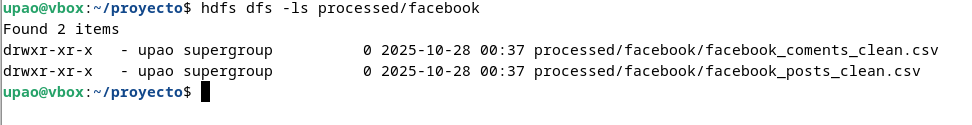

# Deteniendo sesion de spark

In [175]:
spark

In [176]:
spark.stop()
del spark  # elimina la variable

In [242]:
try:
    spark
except NameError:
    print("SparkSession no está creada.")


SparkSession no está creada.
